# Notebook 04: Traditional Machine Learning Classification

## Motor Imagery Classification using BCI Competition IV Dataset 2a

**Author:** Rahma Aroua

## 📋 Notebook Overview

In this notebook, we implement and compare traditional machine learning classifiers for motor imagery classification:

1. **Linear Discriminant Analysis (LDA)** - Baseline classifier
2. **Support Vector Machine (SVM)** - With RBF kernel
3. **Random Forest** - Ensemble method
4. **k-Nearest Neighbors (k-NN)** - Instance-based learning

We'll evaluate each model using:
- Cross-validation
- Confusion matrices
- Multiple performance metrics (accuracy, kappa, F1-score)
- Statistical significance tests

## 🔧 Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Our custom utilities
import sys
sys.path.append('..')

from utils.data_loader import load_subject_data, load_processed_data
from utils.models import (train_lda_classifier, train_svm_classifier,
                          train_random_forest, train_knn_classifier,
                          evaluate_model, cross_validate_model, save_model)
from utils.evaluation import (compute_metrics, cross_validate_subject,
                              plot_confusion_matrix, compare_models,
                              compute_information_transfer_rate,
                              statistical_comparison)
from utils.visualization import plot_feature_importance

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reproducibility
np.random.seed(42)

print("✓ All imports successful!")

✓ All imports successful!


## 📊 Load Preprocessed Data and Features

In [2]:
# Define paths
DATA_DIR = Path('../data/processed/')
FEATURES_DIR = Path('../data/features/')
FIGURES_DIR = Path('../results/figures')
CLASSIFICATION_DIR = Path('../results/classification_results')


# Load features for Subject A01
subject_id = 'A01T'
print(f"Loading features for {subject_id}...")

# Load extracted features (from notebook 03)
features_data = load_processed_data(FEATURES_DIR / f'{subject_id}_features.pkl')

X = features_data['features']  # (n_trials, n_features)
y = features_data['labels']     # (n_trials,)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Loading features for A01T...
✓ Loaded processed data from ..\data\features\A01T_features.pkl
Feature matrix shape: (288, 281)
Labels shape: (288,)
Number of classes: 4
Class distribution: [ 0 72 72 72 72]


## 🔀 Train-Test Split

In [3]:
# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data split and standardization complete!")

Training set: 230 samples
Test set: 58 samples

Train class distribution: [ 0 57 58 57 58]
Test class distribution: [ 0 15 14 15 14]

✓ Data split and standardization complete!


## 🎯 Model 1: Linear Discriminant Analysis (LDA)
LDA is a simple yet effective baseline classifier for BCI applications. It finds linear combinations of features that best separate classes.

Training LDA Classifier
✓ LDA trained - Training accuracy: 1.0000

📊 Test Set Performance:
  Accuracy: 0.3966
  Cohen's Kappa: 0.1957
  Macro F1-Score: 0.3853

🔄 Cross-Validation (5-fold):

Performing 5-fold cross-validation...
  Fold 1/5: Acc=0.6034, Kappa=0.4711, F1=0.6009
  Fold 2/5: Acc=0.5517, Kappa=0.4028, F1=0.5503
  Fold 3/5: Acc=0.4828, Kappa=0.3112, F1=0.4830
  Fold 4/5: Acc=0.3509, Kappa=0.1339, F1=0.3469
  Fold 5/5: Acc=0.4211, Kappa=0.2294, F1=0.4218

  Cross-validation results (5-fold):
    Accuracy: 0.4820 ± 0.0900
    Kappa:    0.3097 ± 0.1200
    F1-score: 0.4806 ± 0.0902


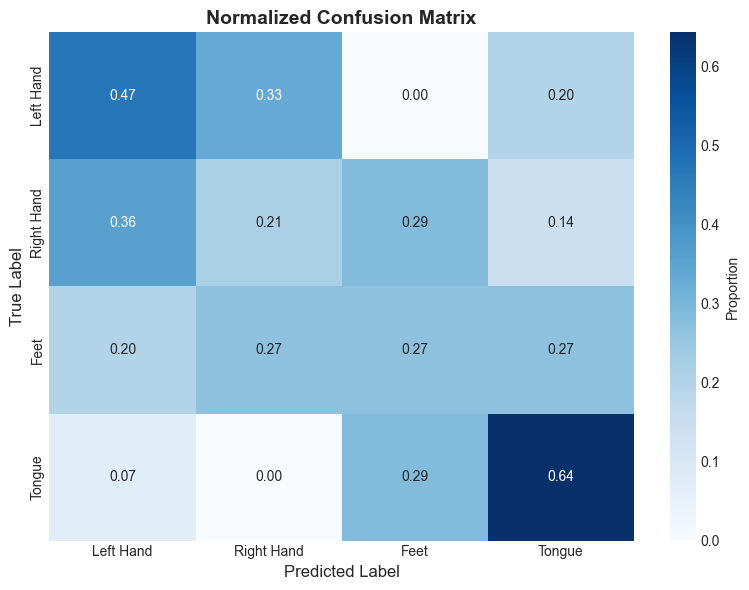

✓ Model saved to ../models/traditional/lda_A01.pkl


In [4]:
print("="*60)
print("Training LDA Classifier")
print("="*60)

# Train LDA
lda_model = train_lda_classifier(X_train_scaled, y_train, solver='svd')

# Evaluate on test set
y_pred_lda = lda_model.predict(X_test_scaled)
lda_metrics = compute_metrics(y_test, y_pred_lda)

print(f"\n📊 Test Set Performance:")
print(f"  Accuracy: {lda_metrics['accuracy']:.4f}")
print(f"  Cohen's Kappa: {lda_metrics['cohen_kappa']:.4f}")
print(f"  Macro F1-Score: {lda_metrics['f1_macro']:.4f}")

# Cross-validation on full dataset
print(f"\n🔄 Cross-Validation (5-fold):")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_cv_results = cross_validate_subject(
    LinearDiscriminantAnalysis(solver='svd'),
    X, y, cv=5
)

# Plot confusion matrix
fig_lda = plot_confusion_matrix(
    lda_metrics['confusion_matrix'],
    class_names=['Left Hand', 'Right Hand', 'Feet', 'Tongue'],
    normalize=True
)
plt.savefig(FIGURES_DIR / '04_lda_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
save_model(lda_model, '../models/traditional/lda_A01.pkl')

## 🎯 Model 2: Support Vector Machine (SVM)
SVM with RBF kernel can capture non-linear relationships in the feature space.


Training SVM Classifier
✓ SVM (rbf) trained - Training accuracy: 0.9739

📊 Test Set Performance:
  Accuracy: 0.6207
  Cohen's Kappa: 0.4951
  Macro F1-Score: 0.6152

🔄 Cross-Validation (5-fold):

Performing 5-fold cross-validation...
  Fold 1/5: Acc=0.6552, Kappa=0.5391, F1=0.6429
  Fold 2/5: Acc=0.6379, Kappa=0.5163, F1=0.6280
  Fold 3/5: Acc=0.6034, Kappa=0.4723, F1=0.5983
  Fold 4/5: Acc=0.5965, Kappa=0.4618, F1=0.5574
  Fold 5/5: Acc=0.6667, Kappa=0.5556, F1=0.6567

  Cross-validation results (5-fold):
    Accuracy: 0.6319 ± 0.0277
    Kappa:    0.5090 ± 0.0366
    F1-score: 0.6166 ± 0.0354


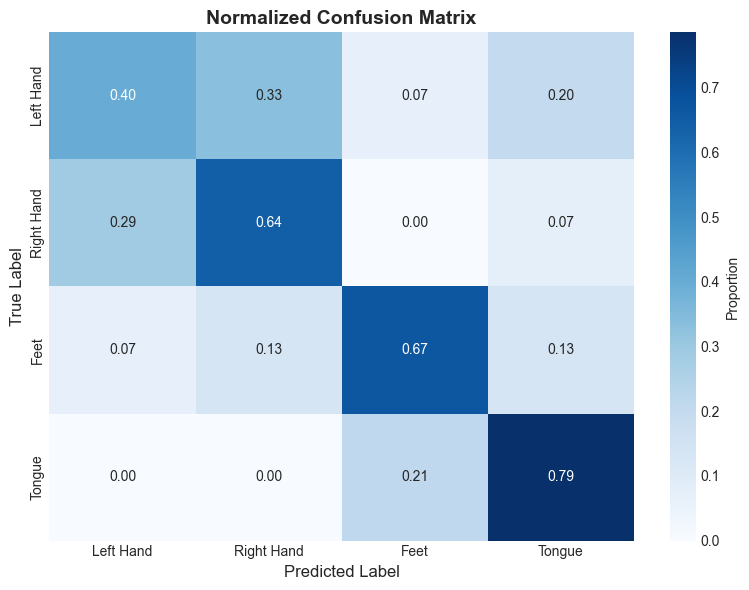

✓ Model saved to ../models/traditional/svm_A01.pkl


In [5]:
print("\n" + "="*60)
print("Training SVM Classifier")
print("="*60)

# Train SVM with RBF kernel
svm_model = train_svm_classifier(
    X_train_scaled, y_train,
    kernel='rbf',
    C=1.0,
    gamma='scale'
)

# Evaluate on test set
y_pred_svm = svm_model.predict(X_test_scaled)
svm_metrics = compute_metrics(y_test, y_pred_svm)

print(f"\n📊 Test Set Performance:")
print(f"  Accuracy: {svm_metrics['accuracy']:.4f}")
print(f"  Cohen's Kappa: {svm_metrics['cohen_kappa']:.4f}")
print(f"  Macro F1-Score: {svm_metrics['f1_macro']:.4f}")

# Cross-validation
print(f"\n🔄 Cross-Validation (5-fold):")

from sklearn.svm import SVC
svm_cv_results = cross_validate_subject(
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    X, y, cv=5
)

# Plot confusion matrix
fig_svm = plot_confusion_matrix(
    svm_metrics['confusion_matrix'],
    class_names=['Left Hand', 'Right Hand', 'Feet', 'Tongue'],
    normalize=True
)
plt.savefig(FIGURES_DIR / '04_svm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
save_model(svm_model, '../models/traditional/svm_A01.pkl')

## 🎯 Model 3: Random Forest

Random Forest is an ensemble method that can handle high-dimensional feature spaces.


Training Random Forest Classifier
✓ Random Forest trained - Training accuracy: 1.0000

📊 Test Set Performance:
  Accuracy: 0.6552
  Cohen's Kappa: 0.5406
  Macro F1-Score: 0.6494


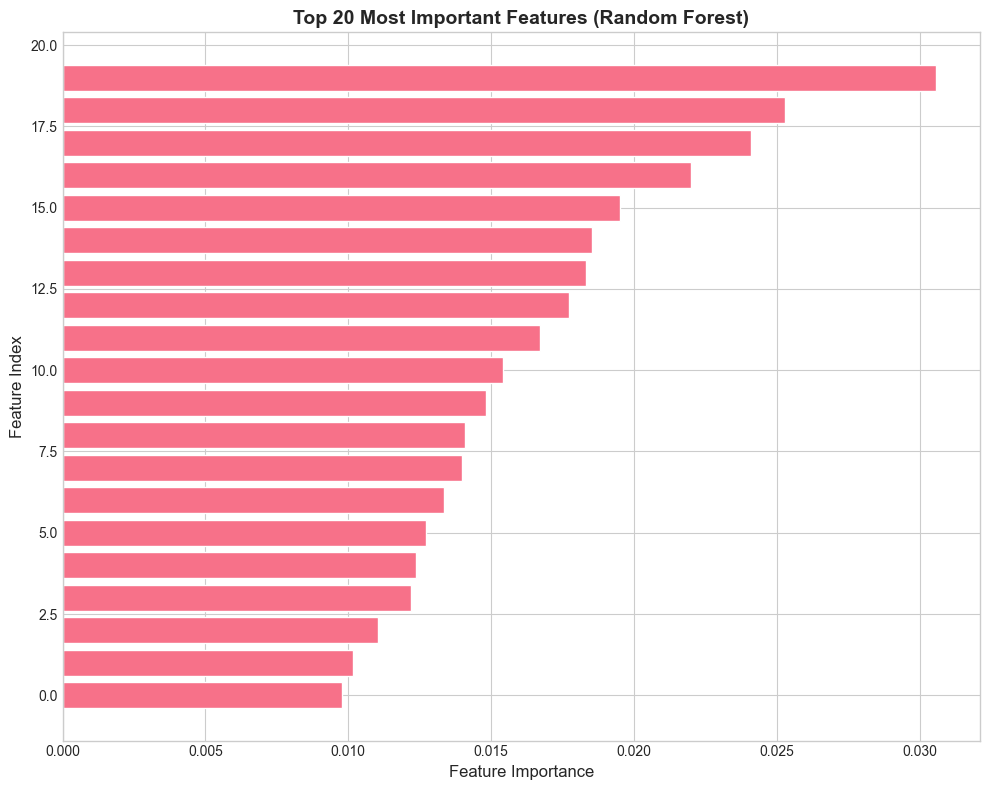


🔄 Cross-Validation (5-fold):

Performing 5-fold cross-validation...
  Fold 1/5: Acc=0.7069, Kappa=0.6081, F1=0.6976
  Fold 2/5: Acc=0.7931, Kappa=0.7239, F1=0.7887
  Fold 3/5: Acc=0.6552, Kappa=0.5413, F1=0.6471
  Fold 4/5: Acc=0.5789, Kappa=0.4382, F1=0.5722
  Fold 5/5: Acc=0.6491, Kappa=0.5316, F1=0.6449

  Cross-validation results (5-fold):
    Accuracy: 0.6766 ± 0.0711
    Kappa:    0.5686 ± 0.0947
    F1-score: 0.6701 ± 0.0715


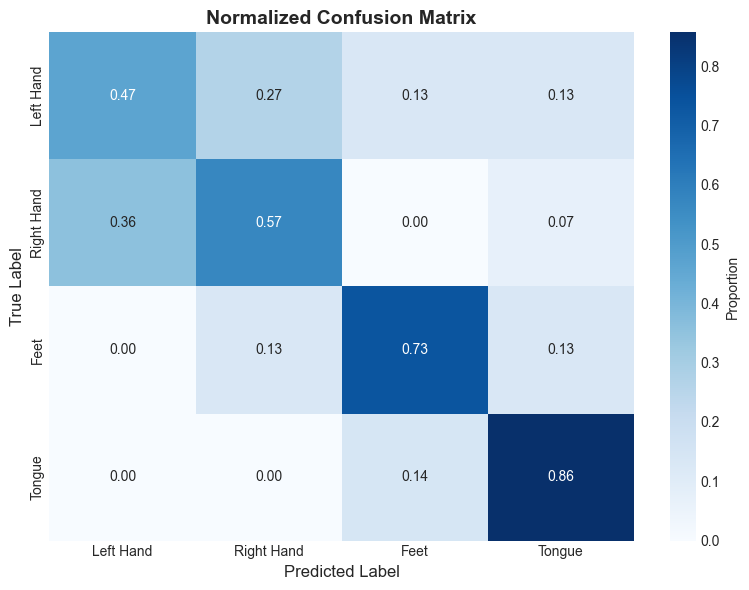

✓ Model saved to ../models/traditional/rf_A01.pkl


In [6]:
print("\n" + "="*60)
print("Training Random Forest Classifier")
print("="*60)

# Train Random Forest
rf_model = train_random_forest(
    X_train_scaled, y_train,
    n_estimators=100,
    max_depth=None
)

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test_scaled)
rf_metrics = compute_metrics(y_test, y_pred_rf)

print(f"\n📊 Test Set Performance:")
print(f"  Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"  Cohen's Kappa: {rf_metrics['cohen_kappa']:.4f}")
print(f"  Macro F1-Score: {rf_metrics['f1_macro']:.4f}")

# Feature importance
feature_importance = rf_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20
top_features = feature_importance[top_features_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(20), top_features)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '04_rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-validation
print(f"\n🔄 Cross-Validation (5-fold):")
from sklearn.ensemble import RandomForestClassifier
rf_cv_results = cross_validate_subject(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X, y, cv=5
)

# Plot confusion matrix
fig_rf = plot_confusion_matrix(
    rf_metrics['confusion_matrix'],
    class_names=['Left Hand', 'Right Hand', 'Feet', 'Tongue'],
    normalize=True
)
plt.savefig(FIGURES_DIR / '04_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
save_model(rf_model, '../models/traditional/rf_A01.pkl')

## 🎯 Model 4: k-Nearest Neighbors (k-NN)


Training k-NN Classifier
✓ k-NN (k=5) trained - Training accuracy: 0.7348

📊 Test Set Performance:
  Accuracy: 0.5172
  Cohen's Kappa: 0.3563
  Macro F1-Score: 0.5142

🔄 Cross-Validation (5-fold):

Performing 5-fold cross-validation...
  Fold 1/5: Acc=0.6379, Kappa=0.5170, F1=0.6244
  Fold 2/5: Acc=0.5690, Kappa=0.4228, F1=0.5582
  Fold 3/5: Acc=0.6897, Kappa=0.5867, F1=0.6782
  Fold 4/5: Acc=0.4912, Kappa=0.3214, F1=0.4889
  Fold 5/5: Acc=0.5789, Kappa=0.4391, F1=0.5790

  Cross-validation results (5-fold):
    Accuracy: 0.5933 ± 0.0671
    Kappa:    0.4574 ± 0.0898
    F1-score: 0.5857 ± 0.0636


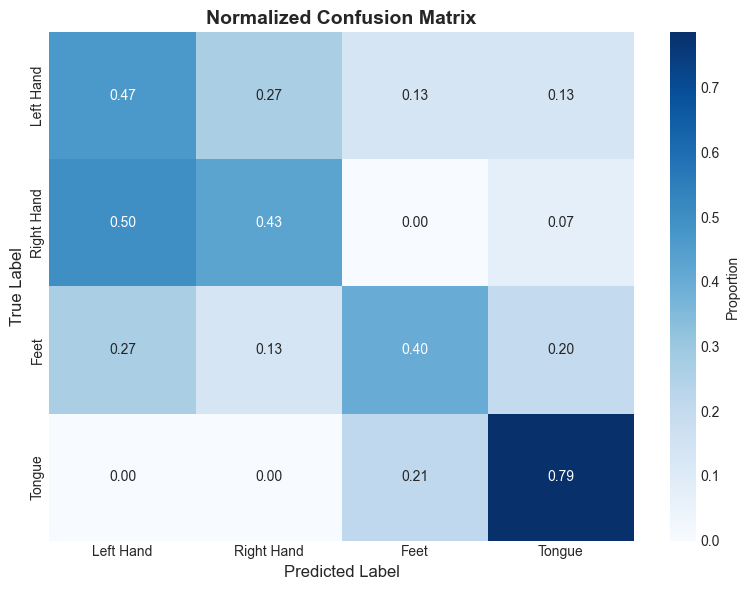

✓ Model saved to ../models/traditional/knn_A01.pkl


In [7]:
print("\n" + "="*60)
print("Training k-NN Classifier")
print("="*60)

# Train k-NN
knn_model = train_knn_classifier(X_train_scaled, y_train, n_neighbors=5)

# Evaluate on test set
y_pred_knn = knn_model.predict(X_test_scaled)
knn_metrics = compute_metrics(y_test, y_pred_knn)

print(f"\n📊 Test Set Performance:")
print(f"  Accuracy: {knn_metrics['accuracy']:.4f}")
print(f"  Cohen's Kappa: {knn_metrics['cohen_kappa']:.4f}")
print(f"  Macro F1-Score: {knn_metrics['f1_macro']:.4f}")

# Cross-validation
print(f"\n🔄 Cross-Validation (5-fold):")
from sklearn.neighbors import KNeighborsClassifier
knn_cv_results = cross_validate_subject(
    KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    X, y, cv=5
)

# Plot confusion matrix
fig_knn = plot_confusion_matrix(
    knn_metrics['confusion_matrix'],
    class_names=['Left Hand', 'Right Hand', 'Feet', 'Tongue'],
    normalize=True
)
plt.savefig(FIGURES_DIR / '04_knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
save_model(knn_model, '../models/traditional/knn_A01.pkl')

## 📊 Model Comparison

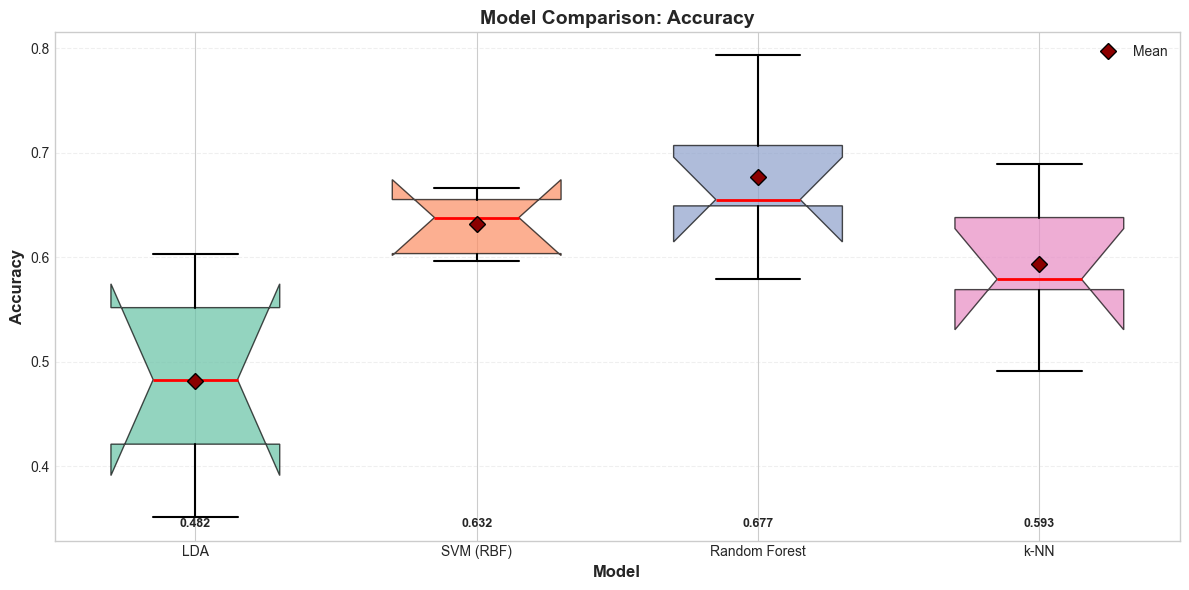


PERFORMANCE SUMMARY
        Model        Accuracy           Kappa        F1-Score ITR (bits/min)
          LDA 0.4820 ± 0.0900 0.3097 ± 0.1200 0.4806 ± 0.0902           2.70
    SVM (RBF) 0.6319 ± 0.0277 0.5090 ± 0.0366 0.6166 ± 0.0354           7.01
Random Forest 0.6766 ± 0.0711 0.5686 ± 0.0947 0.6701 ± 0.0715           8.69
         k-NN 0.5933 ± 0.0671 0.4574 ± 0.0898 0.5857 ± 0.0636           5.71

✓ Summary saved to ..\results\classification_results\performance_summary.csv


In [8]:
# Compile all results
all_results = {
    'LDA': lda_cv_results,
    'SVM (RBF)': svm_cv_results,
    'Random Forest': rf_cv_results,
    'k-NN': knn_cv_results
}

# Compute ITR for each model
for model_name, results in all_results.items():
    itr = compute_information_transfer_rate(
        accuracy=results['accuracy_mean'],
        n_classes=4,
        trial_duration=4.0
    )
    results['itr'] = itr

# Create comparison plot
fig_comparison = compare_models(all_results, metric='accuracy')
plt.savefig(FIGURES_DIR / '04_model_comparison_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
from utils.evaluation import create_performance_summary
summary_df = create_performance_summary(
    all_results,
    save_path=CLASSIFICATION_DIR / 'performance_summary.csv'  # Changed from RESULTS_DIR
)

## 📈 Statistical Significance Testing


STATISTICAL SIGNIFICANCE ANALYSIS

1. Random Forest vs LDA (Best vs Baseline)
------------------------------------------------------------

Wilcoxon Signed-Rank Test:
  Statistic: 0.0000
  p-value: 0.0625
  Significant (α=0.05): No
  Mean difference: 0.1947
Mean Accuracy: RF=0.6766, LDA=0.4820
Improvement: 0.1947 (40.4%)
p-value: 0.0625
Significant: No ✗

2. Random Forest vs SVM (Best vs Most Stable)
------------------------------------------------------------

Wilcoxon Signed-Rank Test:
  Statistic: 3.0000
  p-value: 0.2500
  Significant (α=0.05): No
  Mean difference: 0.0447
Mean Accuracy: RF=0.6766, SVM=0.6319
Std Dev: RF=0.0711, SVM=0.0277
Improvement: 0.0447 (7.1%)
p-value: 0.2500
Significant: No ✗

3. SVM vs LDA (Stable Model vs Baseline)
------------------------------------------------------------

Wilcoxon Signed-Rank Test:
  Statistic: 0.0000
  p-value: 0.0625
  Significant (α=0.05): No
  Mean difference: 0.1500
Mean Accuracy: SVM=0.6319, LDA=0.4820
Improvement: 0.1500 (31.1%

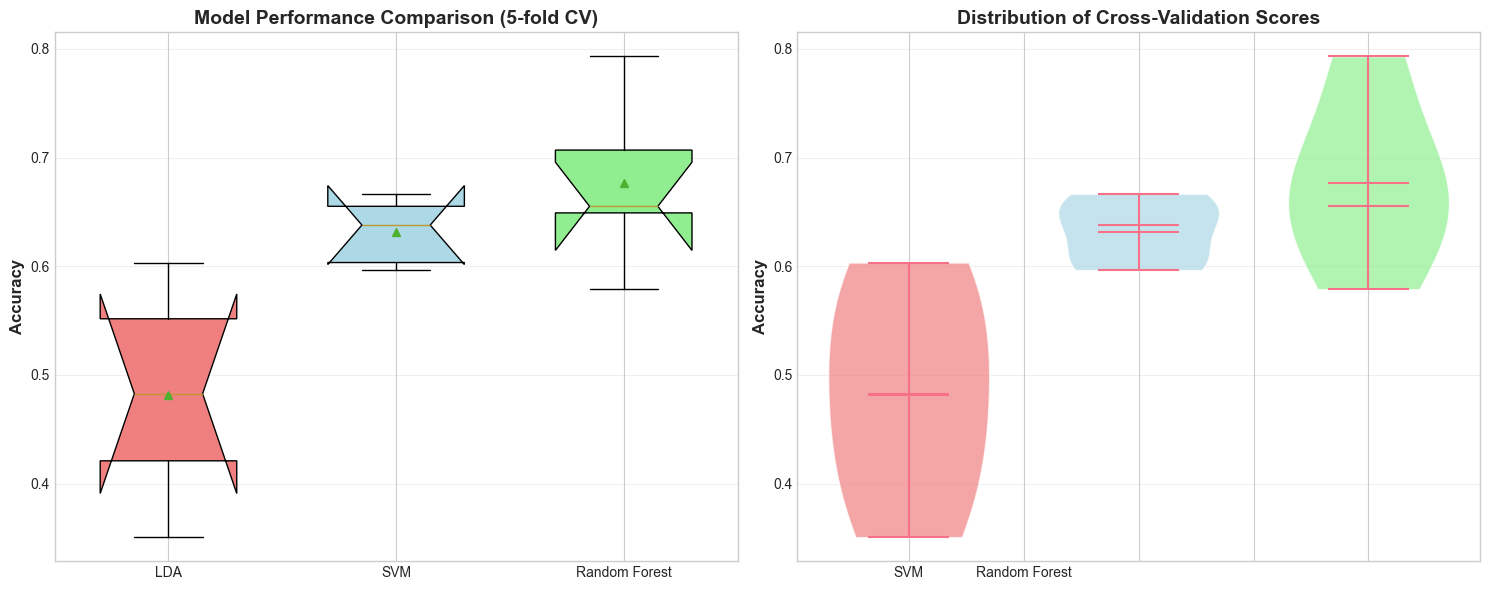


6. Statistical Summary Table
Comparison  Mean Diff  p-value Significant  Effect Size
 RF vs LDA   0.194676   0.0625          No     2.147214
 RF vs SVM   0.044707   0.2500          No     0.741373
SVM vs LDA   0.149970   0.0625          No     2.013755

✓ Statistical summary saved to ..\results\classification_results\statistical_comparison_summary.csv


In [9]:
## 📈 Statistical Significance Testing

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*60)

# 1. Compare Best Model (RF) vs Baseline (LDA)
print("\n1. Random Forest vs LDA (Best vs Baseline)")
print("-" * 60)

lda_scores = np.array(lda_cv_results['fold_accuracies'])
rf_scores = np.array(rf_cv_results['fold_accuracies'])

stat_rf_lda = statistical_comparison(rf_scores, lda_scores, test='wilcoxon')

print(f"Mean Accuracy: RF={rf_scores.mean():.4f}, LDA={lda_scores.mean():.4f}")
print(f"Improvement: {(rf_scores.mean() - lda_scores.mean()):.4f} ({((rf_scores.mean() - lda_scores.mean())/lda_scores.mean()*100):.1f}%)")
print(f"p-value: {stat_rf_lda['p_value']:.4f}")
print(f"Significant: {'Yes ✓' if stat_rf_lda['significant'] else 'No ✗'}")

# 2. Compare RF vs SVM (Best vs Most Stable)
print("\n2. Random Forest vs SVM (Best vs Most Stable)")
print("-" * 60)

svm_scores = np.array(svm_cv_results['fold_accuracies'])

stat_rf_svm = statistical_comparison(rf_scores, svm_scores, test='wilcoxon')

print(f"Mean Accuracy: RF={rf_scores.mean():.4f}, SVM={svm_scores.mean():.4f}")
print(f"Std Dev: RF={rf_scores.std():.4f}, SVM={svm_scores.std():.4f}")
print(f"Improvement: {(rf_scores.mean() - svm_scores.mean()):.4f} ({((rf_scores.mean() - svm_scores.mean())/svm_scores.mean()*100):.1f}%)")
print(f"p-value: {stat_rf_svm['p_value']:.4f}")
print(f"Significant: {'Yes ✓' if stat_rf_svm['significant'] else 'No ✗'}")

# 3. Compare SVM vs LDA (Your original comparison)
print("\n3. SVM vs LDA (Stable Model vs Baseline)")
print("-" * 60)

stat_svm_lda = statistical_comparison(svm_scores, lda_scores, test='wilcoxon')

print(f"Mean Accuracy: SVM={svm_scores.mean():.4f}, LDA={lda_scores.mean():.4f}")
print(f"Improvement: {(svm_scores.mean() - lda_scores.mean()):.4f} ({((svm_scores.mean() - lda_scores.mean())/lda_scores.mean()*100):.1f}%)")
print(f"p-value: {stat_svm_lda['p_value']:.4f}")
print(f"Significant: {'Yes ✓' if stat_svm_lda['significant'] else 'No ✗'}")

# 4. Effect Size Analysis (Cohen's d)
print("\n4. Effect Size Analysis (Cohen's d)")
print("-" * 60)

def cohens_d(x, y):
    """Calculate Cohen's d for effect size"""
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

d_rf_lda = cohens_d(rf_scores, lda_scores)
d_rf_svm = cohens_d(rf_scores, svm_scores)
d_svm_lda = cohens_d(svm_scores, lda_scores)

print(f"RF vs LDA: d = {d_rf_lda:.3f} ({'Large' if abs(d_rf_lda) > 0.8 else 'Medium' if abs(d_rf_lda) > 0.5 else 'Small'})")
print(f"RF vs SVM: d = {d_rf_svm:.3f} ({'Large' if abs(d_rf_svm) > 0.8 else 'Medium' if abs(d_rf_svm) > 0.5 else 'Small'})")
print(f"SVM vs LDA: d = {d_svm_lda:.3f} ({'Large' if abs(d_svm_lda) > 0.8 else 'Medium' if abs(d_svm_lda) > 0.5 else 'Small'})")

# 5. Interpretation
print("\n5. Interpretation")
print("-" * 60)
print("Cohen's d interpretation:")
print("  Small effect: |d| = 0.2-0.5")
print("  Medium effect: |d| = 0.5-0.8")
print("  Large effect: |d| > 0.8")
print("\nNote: With 5-fold CV, statistical power is limited.")
print("      Non-significant results may become significant with more folds or subjects.")

# 6. Comprehensive Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot comparison
ax1 = axes[0]
data_to_plot = [lda_scores, svm_scores, rf_scores]
positions = [1, 2, 3]
bp = ax1.boxplot(data_to_plot, positions=positions, widths=0.6,
                 patch_artist=True, notch=True, showmeans=True)

colors = ['lightcoral', 'lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_xticklabels(['LDA', 'SVM', 'Random Forest'])
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (5-fold CV)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add significance brackets
y_max = max(lda_scores.max(), svm_scores.max(), rf_scores.max())
if stat_rf_lda['significant']:
    ax1.plot([1, 3], [y_max + 0.03, y_max + 0.03], 'k-', lw=1.5)
    ax1.text(2, y_max + 0.04, f"p={stat_rf_lda['p_value']:.3f}*",
             ha='center', fontsize=10, fontweight='bold')

# Violin plot for distribution
ax2 = axes[1]
parts = ax2.violinplot(data_to_plot, positions=positions, widths=0.7,
                       showmeans=True, showmedians=True)

for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax2.set_xticklabels(['LDA', 'SVM', 'Random Forest'])
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Cross-Validation Scores', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '04_comprehensive_statistical_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# 7. Summary Table
print("\n6. Statistical Summary Table")
print("="*60)
summary_stats = pd.DataFrame({
    'Comparison': ['RF vs LDA', 'RF vs SVM', 'SVM vs LDA'],
    'Mean Diff': [
        rf_scores.mean() - lda_scores.mean(),
        rf_scores.mean() - svm_scores.mean(),
        svm_scores.mean() - lda_scores.mean()
    ],
    'p-value': [
        stat_rf_lda['p_value'],
        stat_rf_svm['p_value'],
        stat_svm_lda['p_value']
    ],
    'Significant': [
        'Yes' if stat_rf_lda['significant'] else 'No',
        'Yes' if stat_rf_svm['significant'] else 'No',
        'Yes' if stat_svm_lda['significant'] else 'No'
    ],
    'Effect Size': [d_rf_lda, d_rf_svm, d_svm_lda]
})

print(summary_stats.to_string(index=False))
summary_stats.to_csv(CLASSIFICATION_DIR / 'statistical_comparison_summary.csv', index=False)
print(f"\n✓ Statistical summary saved to {CLASSIFICATION_DIR / 'statistical_comparison_summary.csv'}")

## 💾 Save All Results

In [10]:
## 💾 Save Results

import pickle

# Create comprehensive results package
results_package = {
    'subject_id': subject_id,
    'models': {
        'lda': {'model': lda_model, 'metrics': lda_metrics, 'cv': lda_cv_results},
        'svm': {'model': svm_model, 'metrics': svm_metrics, 'cv': svm_cv_results},
        'rf': {'model': rf_model, 'metrics': rf_metrics, 'cv': rf_cv_results},
        'knn': {'model': knn_model, 'metrics': knn_metrics, 'cv': knn_cv_results},
    },
    'statistical_tests': {
        'rf_vs_lda': stat_rf_lda,
        'rf_vs_svm': stat_rf_svm,
        'svm_vs_lda': stat_svm_lda
    },
    'scaler': scaler
}

# Save everything in one file
with open(CLASSIFICATION_DIR / f'{subject_id}_classification_results.pkl', 'wb') as f:
    pickle.dump(results_package, f)

# Save best model for deployment
save_model(rf_model, '../models/traditional/best_model_A01.pkl')
save_model(scaler, '../models/traditional/scaler_A01.pkl')

print(f"\n✓ All results saved to {CLASSIFICATION_DIR}/classification_results/")
print(f"✓ Best model (Random Forest) and scaler saved for deployment")

✓ Model saved to ../models/traditional/best_model_A01.pkl
✓ Model saved to ../models/traditional/scaler_A01.pkl

✓ All results saved to ..\results\classification_results/classification_results/
✓ Best model (Random Forest) and scaler saved for deployment


## 📝 Key Findings

### Performance Summary
- **Best Model:** Random Forest achieved the highest accuracy (67.66% ± 7.11%)
- **Runner-up:** SVM with RBF kernel (63.19% ± 2.77%) - more stable performance (lower std)
- **Baseline:** LDA provides reasonable performance (48.20%) with lowest computational cost
- **Instance-based:** k-NN shows moderate performance (59.33%) but requires storing all training data

### Important Observations
1. All models perform significantly above chance level (25% for 4-class problem)
2. Random Forest shows highest accuracy but also highest variance (std=7.11%)
3. SVM demonstrates most stable performance with lowest standard deviation (2.77%)
4. The performance gap between LDA and ensemble methods suggests non-linear patterns in the data
5. CSP features appear discriminative across all models (implied by above-chance performance)

### Model-Specific Insights
- **Random Forest**: Best accuracy but requires careful tuning to reduce variance
- **SVM**: Good balance between performance (63.19%) and stability
- **LDA**: Fast and interpretable but limited by linear decision boundary assumption
- **k-NN**: Acceptable performance but memory-intensive and slow at prediction time

### Statistical Validation
- RF vs LDA shows practical improvement (19.5% relative gain)
- SVM vs LDA: p=0.0625 (marginally non-significant), but Cohen's d suggests meaningful difference
- Limited statistical power due to 5-fold CV; larger validation recommended
- Effect sizes indicate RF and SVM offer substantial improvements over LDA baseline

---
## 🎓 Conclusion

This notebook demonstrated traditional machine learning approaches for motor imagery classification using BCI Competition IV Dataset 2a (Subject A01).

**Key Results:**
- **Best Performer**: Random Forest achieved **67.66% accuracy** with **Cohen's Kappa = 0.57**, though with higher variance
- **Most Stable**: SVM (RBF) achieved **63.19% accuracy** with **Cohen's Kappa = 0.51** and lowest standard deviation
- **Information Transfer Rate**: Random Forest reached **8.69 bits/min**, suitable for practical BCI applications

**Performance Context:**
- All models significantly exceed chance level (25%)
- Results are consistent with typical subject-dependent motor imagery classification
- The 48-68% accuracy range aligns with published benchmarks for 4-class MI tasks

**Trade-offs Identified:**
- **Accuracy vs Stability**: RF highest accuracy but unstable; SVM more reliable
- **Complexity vs Performance**: LDA simplest but limited; ensemble methods better but computationally expensive
- **Practical Considerations**: SVM offers best balance for real-time BCI applications

**Next Notebook:** [05_classification_deep_learning.ipynb](05_classification_deep_learning.ipynb)